In [4]:
!pip3 install -U PyBullet 

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [14]:
!pip3 install casadi

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


Follow instructions from https://github.com/casadi/casadi/wiki/InstallationInstructions to download CasADi

In [15]:
# from sys import path
# path.append(r".../casadi-py35-np1.9.1-v3.1.1")
from casadi import *

In [2]:
import numpy as np
from numpy.linalg import inv

In [3]:
import pybullet as p
import time
import pybullet_data
physicsClient = p.connect(p.GUI)#or p.DIRECT for non-graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath()) #optionally
p.setGravity(0,0,-10)
planeId = p.loadURDF("plane.urdf")
startPos = [0,0,1]
startOrientation = p.getQuaternionFromEuler([0,0,0])
boxId = p.loadURDF("r2d2.urdf",startPos)#, startOrientation)
#car = p.loadURDF("f10_racecar/racecar_differential.urdf", [0,0,.3])
#set the center of mass frame (loadURDF sets base link frame) startPos/Ornp.resetBasePositionAndOrientation(boxId, startPos, startOrientation)
for i in range (10000):
    p.stepSimulation()
    time.sleep(1./240.)
cubePos, cubeOrn = p.getBasePositionAndOrientation(boxId)
print(cubePos,cubeOrn)
p.disconnect()


error: Only one local in-process GUI/GUI_SERVER connection allowed. Use DIRECT connection mode or start a separate GUI physics server (ExampleBrowser, App_SharedMemoryPhysics_GUI, App_SharedMemoryPhysics_VR) and connect over SHARED_MEMORY, UDP or TCP instead.

In [4]:
import os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
print("current_dir=" + currentdir)
parentdir = os.path.join(currentdir, "../gym")

os.sys.path.insert(0, parentdir)

import pybullet as p
import pybullet_data

import time

############################################# INVIRONMENT SETUP ###############################################
cid = p.connect(p.SHARED_MEMORY)
if (cid < 0):
    client = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath()) #optionally

p.resetSimulation()
p.setGravity(0, 0, -9.8, physicsClientId = client) # earth's gravity in z direction

useRealTimeSim = 0 # not real time

#for video recording (works best on Mac and Linux, not well on Windows)
#p.startStateLogging(p.STATE_LOGGING_VIDEO_MP4, "racecar.mp4")

#******************************************** BACKGROUND SETUP ************************************************
p.setRealTimeSimulation(useRealTimeSim)  # either this
#plane = p.loadURDF(os.path.join(pybullet_data.getDataPath(),"plane.urdf"))
plane = p.loadSDF("stadium.sdf")

#********************************************* OBJECT(S) SETUP ************************************************
car = p.loadURDF("racecar/racecar.urdf",basePosition=[0,0,0])
# for i in range(p.getNumJoints(car)): # uncomment to see labels for all joints
#     print(p.getJointInfo(car, i))

inactive_wheels = [3, 5, 7] # all other wheel joint
wheels = [2] # name:left rear wheel joint, in sim: left front wheel joint

for wheel in inactive_wheels:
    p.setJointMotorControl2(car, wheel, p.VELOCITY_CONTROL, targetVelocity=0, force=0)

steering = [4, 6] # left and right steering hinge joints

#****************************************** INTERACTIVE SLIDERS SETUP *****************************************
targetVelocitySlider = p.addUserDebugParameter("wheelVelocity", -10, 10, 0) 
maxForceSlider = p.addUserDebugParameter("maxForce", 0, 10, 10)
steeringSlider = p.addUserDebugParameter("steering", -0.5, 0.5, 0)


########################################### EXECUTION LOOP ####################################################
#while (True):
for i in range(10000):
    # car body positions and velocities
    position, orientation = p.getBasePositionAndOrientation(car)
    x, y, z = position
    roll, pitch, yaw = p.getEulerFromQuaternion(orientation) # angular positions
    linear_velocity, angular_velocity = p.getBaseVelocity(car)
    dx, dy, dz = linear_velocity
    droll, dpitch, dyaw = angular_velocity
    theta = yaw
    dtheta = dyaw
    print(f"car body, {i:5}: x={x:0.10f}, y={y:0.10f}, dx={dx:0.10f}, dy={dy:0.10f}, yaw={yaw:0.10f}, dyaw={dyaw:0.10f}")
    
    # left front wheel steering angle and angular velocity
    position, velocity, _, _ = p.getJointState(car,steering[0])
    theta_w = position
    dtheta_w = velocity
    print(f"wheel, {i:5}: wheel theta={theta_w:0.10f}, d wheel theta={dtheta_w:0.10f}")

    # interactive sliders
    maxForce = p.readUserDebugParameter(maxForceSlider)
    targetVelocity = p.readUserDebugParameter(targetVelocitySlider)
    steeringAngle = p.readUserDebugParameter(steeringSlider)
    #print(targetVelocity)

    for wheel in wheels:
        p.setJointMotorControl2(car,
                                wheel,
                                p.VELOCITY_CONTROL,
                                targetVelocity=targetVelocity,
                                force=maxForce)

    for steer in steering:
        p.setJointMotorControl2(car, 
                                steer, 
                                p.POSITION_CONTROL, 
                                targetPosition=steeringAngle)


    steering
    if (useRealTimeSim == 0):
        p.stepSimulation()
        
    
    time.sleep(1./240.) # 24 frames per second
p.disconnect()

current_dir=/home/chau/Documents/University of Washington/Winter 2022/EE 546 Optimization ad Learning for Control/Project


error: Only one local in-process GUI/GUI_SERVER connection allowed. Use DIRECT connection mode or start a separate GUI physics server (ExampleBrowser, App_SharedMemoryPhysics_GUI, App_SharedMemoryPhysics_VR) and connect over SHARED_MEMORY, UDP or TCP instead.

Robot dynamics:

$M(q)\ddot q + C(q,\dot q)\dot q + G(q) + A(q)^\top \lambda = B(q)u + F$

where

$M(q)$ is the intertial matrix

$C(q,\dot q)\dot q)$ is the centrifugal and Coriolis forces

$G(q)$ is the potentials (gravity)

$A(q)^\top \lambda$ are constraint forces (where $\lambda$ are unknown multiplier a priori)

$B(q)$ maps control inputs $u$ into generalized forces

$F$ contains non-conservative forces such as friction

$q = [x,y,\theta,\theta_w]^\top$

$(x,y)$ is the center of mass coordinates of the car in the world frame

$\theta$ is the yaw angle of the car with respect to the global x-axis

$\theta_w$ is the steering angle of the front wheels with respect to the car's x-axis

In [5]:
# constants
r = 1 # wheel radius
m = 1.26 # mass of the body of car
J = 0.0064 # inertia of body
J1 = 3.5e-6 # inertia of front wheel
m1 = 0.01 # mass of one of the front wheels
m2 = 0.01 # mass of one of the rear wheels
L_R = 0.09 # length from center of mass (COM) to rear wheel
L_F = 0.09 # length from COM to front wheel
g = 9.8 #m/s**2 gravity
F_x_F = 1 # friction on front wheel in x direction
F_y_F = 1 # friction on front wheel in y direction
F_x_R = 1 # friction on rear wheel in x direction
F_y_R = 1 # friction on rear wheel in y direction


##################################### FUNCTIONS FOR DYNAMICS CONSTRAINTS #####################################
def M(q):
    # states
    x,y,theta,theta_w = q
    
    M11 = m + m1 + m2
    M22 = M11
    M33 = m2*(L_R**2) + m1*(L_F**2) + J1 + J
    M44 = J1
    
    M12 = 0
    M13 = np.sin(theta)*(m2*L_R - m1*L_F)
    M14 = 0
    
    M21 = 0
    M23 = -np.cos(theta)(m2*L_R - m1*L_F)
    M24 = 0
    
    M31 = M13
    M32 = M23
    M34 = M44
    
    M41 = 0
    M42 = 0
    M43 = M44
    
    M = np.array([[M11,M12,M13,M14],
                 [M21,M22,M23,M24],
                 [M31,M32,M33,M34],
                 [M41,M42,M43,M44]])
    return M


def C_times_dq(q,dq):
    # states
    x,y,theta,theta_w = q
    dx,dy,dtheta,dtheta_w = dq
    
    C1 = (dtheta**2) * np.cos(m2*L_R - m2*L_F)
    C2 = (dtheta**2) * np.sin(m2*L_R - m1*L_F)
    
    C_dq = np.array([[C1],
                    [C2],
                    [0],
                    [0]])
    return C_dq


def G(q):
    return 0 # no gravity on position variables x,y,theta,theta_w


def A(q): # no slip, no skid constraints
    # needs np.dot(A(q),dq) = 0
    
    # states
    x,y,theta,theta_w = q
    
    A = np.array([[np.cos(theta),np.sin(theta),0,-r],
                 [-np.sin(theta),np.cos(theta),0,0]])
    return A


def dA(q):
    # states
    x,y,theta,theta_w = q
    
    dA = np.array([[-np.sin(theta),np.cos(theta),0,0],
                  [-np.cos(theta),-np.sin(theta),0,0]])
    return dA


def B(q):
    # states
    x,y,theta,theta_w = q
    
    B11 = np.cos(theta + theta_w) + np.cos(theta)
    B21 = np.sin(theta + theta_w) + np.sin(theta)
    B31 = L_F * np.sin(theta)
    
    B = np.array([[B11,0],
                 [B21,0],
                 [B31,0],
                 [0,1]])
    return B


def _lambda(q,dq,u):
    _lambda = inv(A(q) @ inv(M(q)) @ A(q).T)
    _lambda = _lambda @ ( (A(q) @ inv(M(q))) @ (np.dot(B(q),u) - C_times_dq(q,dq) - G(q)) + np.dot(dA(q),dq) )
    return _lambda


def F(q): # friction forces
    # states
    x,y,theta,theta_w = q
    
    # friction on the front wheel in the global x direction
    F_x_F_global = np.cos(theta + theta_w) * F_x_F + np.sin(theta + theta_w) * F_y_F
    # friction on the front wheel in the global y direction
    F_y_F_global = -np.sin(theta + theta_w) * F_x_F + np.cos(theta + theta_w) * F_y_F
    
    # friction on the rear wheel in the global x direction
    F_x_R_global = np.cos(theta) * F_x_R + np.sin(theta) * F_y_R
    # friction on the rear wheel in the global y direction
    F_y_R_global = -np.sin(theta) * F_x_R + np.cos(theta) * F_y_R
    
    # F matrix
    F1 = F_x_F_global + F_x_R_global
    F2 = F_y_F_glpbal + F_y_R_global
    F3 = - F_x_F_global*L_F*np.sin(theta) + F_x_R_global*L_R*np.sin(theta) + F_y_F_global*L_F*np.cos(theta) - F_y_R_global*L_R*np.cos(theta)
    
    F = np.array([[F1],
                  [F2],
                  [F3],
                  [0]])
    return F
    

def dynamics(q_next,dq_next,u_next,h=1): # discretized dynamics
    # h is time step
    
    #ddq_next = inv(M(q_next)) @ ( np.dot(B(q_next),u_next) + Fn_next + J(q_next).T @ F_fric_next - C_times_dq(q_next) - G(q_next) )
    ddq_next = inv(M(q_next)) @ ( np.dot(B(q_next),u_next) + F(q_next) - C_times_dq(q_next) - G(q_next) - np.dot(A(q_next).T, _lambda(q_next,dq_next,u_next)) )
    q = q_next - h*dq_next
    dq = dq_next - h*ddq_next
    
    return q,dq
    
    

In [18]:
############################################ COST FUNCTION ####################################################
def cost(q_goal,q,alpha_x=1,alpha_y=1,alpha_theta=0):
    x_g,y_g,theta_g = q_goal
    x,y,theta = q
    x_cost = alpha_x*(x_g - x)**2
    y_cost = alpha_y*(y_g - y)**2
    theta_cost = alpha_theta*(theta_g - theta)**2
    J = x_cost + y_cost + theta_cost
    return J

In [3]:
############################################# NLP SOLVER ######################
from casadi import *

def nlp(cost,q0,dq0,Q_goal,N=100):
    
    # N is number of control steps

    opti = Opti() # Optimization problem

    # ---- decision variables ----
    Q = opti.variable(4,N+1) # q
    dQ = opti.variable(4,N+1) # dq
    U = opti.variable(1,N) # control throttle or torque
    T = opti.variable()

    # ---- objective ----
    opti.minimize(cost(Q_goal,Q))

    # ---- dynamics constraints ----
    # use dynamics()
    f = dynamics

    # ---- Runge-Kutta 4 ----
    dt = T/N
    for k in range(N): # loop over control intervals
        # Runge-Kutta 4 integration
        k1 = f(Q[:,k],            dQ[:,k],            U[:,k])
        k2 = f(Q[:,k]+dt/2*k1[0], dQ[:,k]+dt/2*k1[1], U[:,k])
        k3 = f(Q[:,k]+dt/2*k2[0], dQ[:,k]+dt/2*k2[1], U[:,k])
        k4 = f(Q[:,k]+dt*k3[0],   dQ[:,k]+dt*k3[1],   U[:,k])
        q_next = Q[:,k] + dt/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0])
        dq_next = dQ[:,k] + dt/6*(k1[1]+2*k2[1]+2*k3[1]+k4[1])
        opti.subject_to(Q[:,k+1]==q_next) # close the gaps
        opti.subject_to(dQ[:,k+1]==dq_next)

    # ---- boundary conditions ----
    opti.subject_to(Q[0]==q0) # start at current position
    opti.subject_to(dQ[0]==dq0)
    opti.subject_to(Q[-1]==Q_goal) # finish at goal

    # ---- initial values for solver ----
    opti.set_initial(dQ,[1,1,0.1])
    opti.set_initial(T,1)

    # ---- solve NLP ----
    opti.solver("ipopt")
    sol = opti.solve()
    return sol

NameError: name 'cost' is not defined

In [1]:
import os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
#print("current_dir=" + currentdir)
parentdir = os.path.join(currentdir, "../gym")

os.sys.path.insert(0, parentdir)

import pybullet as p
import pybullet_data

import time
import numpy as np
import random
from casadi import *

# constants
r = 1 # wheel radius
m = 1.26 # mass of the body of car
J = 0.0064 # inertia of body
J1 = 3.5e-6 # inertia of front wheel
m1 = 0.01 # mass of one of the front wheels
m2 = 0.01 # mass of one of the rear wheels
L_R = 0.09 # length from center of mass (COM) to rear wheel
L_F = 0.09 # length from COM to front wheel
g = 9.8 #m/s**2 gravity
F_x_F = 1 # friction on front wheel in x direction
F_y_F = 1 # friction on front wheel in y direction
F_x_R = 1 # friction on rear wheel in x direction
F_y_R = 1 # friction on rear wheel in y direction


##################################### FUNCTIONS FOR DYNAMICS CONSTRAINTS #####################################
def M(q):
    # states
    x = q[0]
    y = q[1]
    theta = q[2]
    theta_w = q[3]
    
    M11 = m + m1 + m2
    M22 = M11
    M33 = m2*(L_R**2) + m1*(L_F**2) + J1 + J
    M44 = J1
    
    M12 = 0
    M13 = np.sin(theta)*(m2*L_R - m1*L_F)
    M14 = 0
    
    M21 = 0
    M23 = -np.cos(theta)*(m2*L_R - m1*L_F)
    M24 = 0
    
    M31 = M13
    M32 = M23
    M34 = M44
    
    M41 = 0
    M42 = 0
    M43 = M44
    
    M = np.array([[M11,M12,M13,M14],
                 [M21,M22,M23,M24],
                 [M31,M32,M33,M34],
                 [M41,M42,M43,M44]])
    return M


def C_times_dq(q,dq):
    # states
    x = q[0]
    y = q[1]
    theta = q[2]
    theta_w = q[3]
    
    dx = dq[0]
    dy = dq[1]
    dtheta = dq[2]
    dtheta_w = dq[3]
    
    C1 = (dtheta**2) * np.cos(m2*L_R - m2*L_F)
    C2 = (dtheta**2) * np.sin(m2*L_R - m1*L_F)
    
    C_dq = np.array([[C1],
                    [C2],
                    [0],
                    [0]])
    return C_dq


def G(q):
    return 0 # no gravity on position variables x,y,theta,theta_w


def A(q): # no slip, no skid constraints
    # needs np.dot(A(q),dq) = 0
    
    # states
    x = q[0]
    y = q[1]
    theta = q[2]
    theta_w = q[3]
    
    A = np.array([[np.cos(theta),np.sin(theta),0,-r],
                 [-np.sin(theta),np.cos(theta),0,0]])
    return A


def dA(q):
    # states
    x = q[0]
    y = q[1]
    theta = q[2]
    theta_w = q[3]
    
    dA = np.array([[-np.sin(theta),np.cos(theta),0,0],
                  [-np.cos(theta),-np.sin(theta),0,0]])
    return dA


def B(q):
    # states
    x = q[0]
    y = q[1]
    theta = q[2]
    theta_w = q[3]
    
    B11 = np.cos(theta + theta_w) + np.cos(theta)
    B21 = np.sin(theta + theta_w) + np.sin(theta)
    B31 = L_F * np.sin(theta)
    
    B = np.array([[B11,0],
                 [B21,0],
                 [B31,0],
                 [0,1]])
    return B


def _lambda(q,dq,u):
    _lambda = inv(A(q) @ inv(M(q)) @ A(q).T)
    _lambda = _lambda @ ( (A(q) @ inv(M(q))) @ (np.dot(B(q),u) - C_times_dq(q,dq) - G(q)) + np.dot(dA(q),dq) )
    return _lambda


def F(q): # friction forces
    # states
    x = q[0]
    y = q[1]
    theta = q[2]
    theta_w = q[3]
    
    # friction on the front wheel in the global x direction
    F_x_F_global = np.cos(theta + theta_w) * F_x_F + np.sin(theta + theta_w) * F_y_F
    # friction on the front wheel in the global y direction
    F_y_F_global = -np.sin(theta + theta_w) * F_x_F + np.cos(theta + theta_w) * F_y_F
    
    # friction on the rear wheel in the global x direction
    F_x_R_global = np.cos(theta) * F_x_R + np.sin(theta) * F_y_R
    # friction on the rear wheel in the global y direction
    F_y_R_global = -np.sin(theta) * F_x_R + np.cos(theta) * F_y_R
    
    # F matrix
    F1 = F_x_F_global + F_x_R_global
    F2 = F_y_F_glpbal + F_y_R_global
    F3 = - F_x_F_global*L_F*np.sin(theta) + F_x_R_global*L_R*np.sin(theta) + F_y_F_global*L_F*np.cos(theta) - F_y_R_global*L_R*np.cos(theta)
    
    F = np.array([[F1],
                  [F2],
                  [F3],
                  [0]])
    return F
    

def dynamics(q_next,dq_next,u_next,h=1): # discretized dynamics
    # h is time step
    
    #ddq_next = inv(M(q_next)) @ ( np.dot(B(q_next),u_next) + Fn_next + J(q_next).T @ F_fric_next - C_times_dq(q_next) - G(q_next) )
    ddq_next = inv(M(q_next)) @ ( np.dot(B(q_next),u_next) + F(q_next) - C_times_dq(q_next) - G(q_next) - np.dot(A(q_next).T, _lambda(q_next,dq_next,u_next)) )
    q = q_next - h*dq_next
    dq = dq_next - h*ddq_next
    
    return q,dq
    
############################################ COST FUNCTION ####################################################
# not used for now
def cost(q_goal,q,alpha_x=1,alpha_y=1,alpha_theta=0):
    x_g,y_g,theta_g = q_goal
    x,y,theta = q
    x_cost = alpha_x*(x_g - x)**2
    y_cost = alpha_y*(y_g - y)**2
    theta_cost = alpha_theta*(theta_g - theta)**2
    J = x_cost + y_cost + theta_cost
    return J

############################################# NLP SOLVER ######################
from casadi import *

def nlp(q0,dq0,Q_goal,N=100):
    
    # N is number of control steps

    opti = Opti() # Optimization problem

    # ---- decision variables ----
    Q = opti.variable(4,N+1) # q
    X = Q[0,:]
    Y = Q[1,:]
    THETA = Q[2,:]
    THETA_W = Q[3,:]
    
    dQ = opti.variable(4,N+1) # dq
    dX = dQ[0,:]
    dY = dQ[1,:]
    dTHETA = dQ[2,:]
    dTHETA_W = dQ[3,:]
    
    U = opti.variable(1,N) # control throttle or torque
    T = opti.variable()

    # ---- objective ----
    x_g,y_g,theta_g = Q_goal
    opti.minimize((x_g - X[0])**2 + (y_g - Y[0])**2)

    # ---- dynamics constraints ----
    # use dynamics()
    f = dynamics

    # ---- Runge-Kutta 4 ----
    dt = T/N
    for k in range(N): # loop over control intervals
        # Runge-Kutta 4 integration
        k1 = f(Q[:,k],            dQ[:,k],            U[:,k], dt)
        k2 = f(Q[:,k]+dt/2*k1[0], dQ[:,k]+dt/2*k1[1], U[:,k], dt)
        k3 = f(Q[:,k]+dt/2*k2[0], dQ[:,k]+dt/2*k2[1], U[:,k], dt)
        k4 = f(Q[:,k]+dt*k3[0],   dQ[:,k]+dt*k3[1],   U[:,k], dt)
        q_next = Q[:,k] + dt/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0])
        dq_next = dQ[:,k] + dt/6*(k1[1]+2*k2[1]+2*k3[1]+k4[1])
        opti.subject_to(Q[:,k+1]==q_next) # close the gaps
        opti.subject_to(dQ[:,k+1]==dq_next)

    # ---- boundary conditions ----
    opti.subject_to(Q[0]==q0) # start at current position
    opti.subject_to(dQ[0]==dq0)
    opti.subject_to(Q[-1]==Q_goal) # finish at goal

    # ---- initial values for solver ----
    opti.set_initial(dQ,[1,1,0.1])
    opti.set_initial(T,1)

    # ---- solve NLP ----
    opti.solver("ipopt")
    sol = opti.solve()
    return sol

############################################# INVIRONMENT SETUP ###############################################
cid = p.connect(p.SHARED_MEMORY)
if (cid < 0):
    client = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath()) #optionally

p.resetSimulation()
p.setGravity(0, 0, -9.8, physicsClientId = client) # earth's gravity in z direction

useRealTimeSim = 0 # not real time

#for video recording (works best on Mac and Linux, not well on Windows)
#p.startStateLogging(p.STATE_LOGGING_VIDEO_MP4, "racecar.mp4")

#******************************************** BACKGROUND SETUP ************************************************
p.setRealTimeSimulation(useRealTimeSim)
#plane = p.loadURDF(os.path.join(pybullet_data.getDataPath(),"plane.urdf"))
plane = p.loadSDF("stadium.sdf")

#********************************************* OBJECT(S) SETUP ************************************************
car = p.loadURDF("racecar/racecar.urdf",basePosition=[0,0,0])
# for i in range(p.getNumJoints(car)): # uncomment to see labels for all joints
#     print(p.getJointInfo(car, i))

inactive_wheels = [3, 5, 7] # all other wheel joint
wheels = [2] # name:left rear wheel joint, in sim: left front wheel joint

for wheel in inactive_wheels:
    p.setJointMotorControl2(car, wheel, p.VELOCITY_CONTROL, targetVelocity=0, force=0)

steering = [4, 6] # left and right steering hinge joints

for i in range(1000):
    ####################################### STATE CONTRAINTS ########################################
    # initial states
    # car body positions and velocities
    position, orientation = p.getBasePositionAndOrientation(car)
    x, y, z = position
    roll, pitch, yaw = p.getEulerFromQuaternion(orientation) # angular positions
    linear_velocity, angular_velocity = p.getBaseVelocity(car)
    dx, dy, dz = linear_velocity
    droll, dpitch, dyaw = angular_velocity
    theta = yaw
    dtheta = dyaw
    #print(f"car body, x={x:0.10f}, y={y:0.10f}, dx={dx:0.10f}, dy={dy:0.10f}, yaw={yaw:0.10f}, dyaw={dyaw:0.10f}")

    # left front wheel steering angle and angular velocity
    position, velocity, _, _ = p.getJointState(car,steering[0])
    theta_w = position
    dtheta_w = velocity
    #print(f"wheel, wheel theta={theta_w:0.10f}, d wheel theta={dtheta_w:0.10f}")

    q0 = np.array([x,y,theta,theta_w])
    dq0 = np.array([dx,dy,dtheta,dtheta_w])

    # goal
    x_g = random.uniform(-1,2)
    y_g = random.uniform(-1,2)
    theta_g = random.uniform(-1,1)
    Q_goal = [x_g,y_g,theta_g]

    # joint position limit
    theta_w_min = -0.5
    theta_w_max = 0.5

    # joint velocity limit
    dtheta_w_min = -0.5
    dtheta_w_max = 0.5

    # bounds for input torque u: physical constraints from robot
    # bounds for input torque u: constraints from ranges of dq
    
    maxForce = 10
    
    ######### NLP ###########
    sol = nlp(q0,dq0,Q_goal)
    
    for i in range(len(sol.value(X))):
        ########## Simulation ########
        v = np.cos(sol.value(dX)[i]) + np.sin(sol.value(dY)[i])
        p.setJointMotorControlArray(car,
                                    wheels,
                                    p.VELOCITY_CONTROL,
                                    targetVelocity=v,
                                    force=maxForce)

        p.setJointMotorControlArray(car, 
                                    steering, 
                                    p.POSITION_CONTROL, 
                                    targetPosition=sol.value(THETA_W)[i])


        steering
        if (useRealTimeSim == 0):
            p.stepSimulation()

        time.sleep(1./240.) # 24 frames per second
p.disconnect()

Exception: Implicit conversion of symbolic CasADi type to numeric matrix not supported.
This may occur when you pass a CasADi object to a numpy function.
Use an equivalent CasADi function instead of that numpy function.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      903
Number of nonzeros in inequality constraint Jacobian.:      303
Number of nonzeros in Lagrangian Hessian.............:      302

Total number of variables............................:      303
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

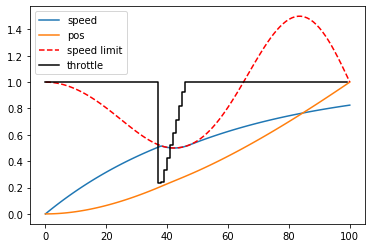

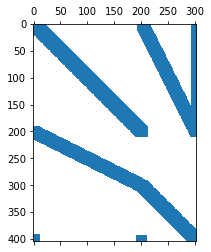

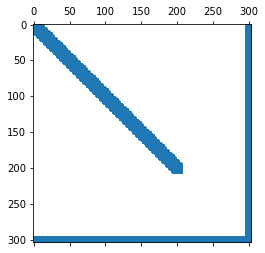

In [1]:
############### Race car NLP solver ##############
# Car race along a track
# ----------------------
# An optimal control problem (OCP),
# solved with direct multiple-shooting.
#
# For more information see: http://labs.casadi.org/OCP
from casadi import *

N = 100 # number of control intervals

opti = Opti() # Optimization problem

# ---- decision variables ---------
X = opti.variable(2,N+1) # state trajectory
pos   = X[0,:]
speed = X[1,:]
U = opti.variable(1,N)   # control trajectory (throttle)
T = opti.variable()      # final time

# ---- objective          ---------
opti.minimize(T) # race in minimal time

# ---- dynamic constraints --------
f = lambda x,u: vertcat(x[1],u-x[1]) # dx/dt = f(x,u)

dt = T/N # length of a control interval
for k in range(N): # loop over control intervals
   # Runge-Kutta 4 integration
   k1 = f(X[:,k],         U[:,k])
   k2 = f(X[:,k]+dt/2*k1, U[:,k])
   k3 = f(X[:,k]+dt/2*k2, U[:,k])
   k4 = f(X[:,k]+dt*k3,   U[:,k])
   x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
   opti.subject_to(X[:,k+1]==x_next) # close the gaps

# ---- path constraints -----------
limit = lambda pos: 1-sin(2*pi*pos)/2
opti.subject_to(speed<=limit(pos))   # track speed limit
opti.subject_to(opti.bounded(0,U,1)) # control is limited

# ---- boundary conditions --------
opti.subject_to(pos[0]==0)   # start at position 0 ...
opti.subject_to(speed[0]==0) # ... from stand-still 
opti.subject_to(pos[-1]==1)  # finish line at position 1

# ---- misc. constraints  ----------
opti.subject_to(T>=0) # Time must be positive

# ---- initial values for solver ---
opti.set_initial(speed, 1)
opti.set_initial(T, 1)

# ---- solve NLP              ------
opti.solver("ipopt") # set numerical backend
sol = opti.solve()   # actual solve

# ---- post-processing        ------
from pylab import plot, step, figure, legend, show, spy

plot(sol.value(speed),label="speed")
plot(sol.value(pos),label="pos")
plot(limit(sol.value(pos)),'r--',label="speed limit")
step(range(N),sol.value(U),'k',label="throttle")
legend(loc="upper left")

figure()
spy(sol.value(jacobian(opti.g,opti.x)))
figure()
spy(sol.value(hessian(opti.f+dot(opti.lam_g,opti.g),opti.x)[0]))

show()